In [3]:
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import timedelta
from timeit import default_timer
import xhistogram.xarray as xhx
import seaborn as sns
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 14
})
import matplotlib.colors as colors




In [4]:
dummy = xr.open_mfdataset("/pscratch/sd/a/amahesh/hens/demo_bred_1step/ensemble_out_0000*_2020-06-18-00-00-00.nc",
                     group='global', concat_dim='ensemble', combine='nested')

In [6]:
def load_hens_min_satisfactory_ensemble_size(curr_date, curr_date_idx):
    stats_ds = xr.open_dataset(f"/pscratch/sd/a/amahesh/hens_h5/stats/t2m_{curr_date:%Y%m%d}_reduced-lead-04-07-10.h5")
    stats_ds = stats_ds.rename({"phony_dim_4" : 'ensemble_size',
                    "phony_dim_2" : 'lat',
                     "phony_dim_3" : 'lon',
                     'phony_dim_1' : 'time'})
    stats_ds['lat'] = dummy['lat']
    stats_ds['lon'] = dummy['lon']
    data = stats_ds['t2m_satisfactory_ens_size'].isel(phony_dim_0=curr_date_idx)
    
    data_bool = data == 1

    # Find the minimum satisfactory ensemble size
    min_satisfactory_ensemble_size = data_bool.argmax(dim='ensemble_size')

    # Mask locations where no satisfactory ensemble size is found
    # data_bool.max(dim='ensemble_size') will be 0 where no 1 is found
    min_satisfactory_ensemble_size = min_satisfactory_ensemble_size.where(data_bool.max(dim='ensemble_size') == 1, other=np.nan)
    return min_satisfactory_ensemble_size

def load_hens_satisfactory_ensemble_size(curr_date, curr_date_idx):
    stats_ds = xr.open_dataset(f"/pscratch/sd/a/amahesh/hens_h5/stats/t2m_{curr_date:%Y%m%d}_reduced-lead-04-07-10.h5")
    stats_ds = stats_ds.rename({"phony_dim_4" : 'ensemble_size',
                    "phony_dim_2" : 'lat',
                     "phony_dim_3" : 'lon',
                     'phony_dim_1' : 'time'})
    stats_ds['lat'] = dummy['lat']
    stats_ds['lon'] = dummy['lon']
    data = stats_ds['t2m_satisfactory_ens_size'].isel(phony_dim_0=curr_date_idx)
    return data
    
def load_era5(curr_date):
    valid_date = curr_date + timedelta(days=10)
    print(valid_date)
    true = xr.open_dataset("/pscratch/sd/p/pharring/74var-6hourly/staging/2023.h5", mode='r')
    true = true.rename({'phony_dim_0' : 'time',
                        'phony_dim_2' : 'lat', 
                 'phony_dim_3' : 'lon',
                 'phony_dim_1' : 'channel'})
    true['lat'] = dummy['lat']
    true['lon'] = dummy['lon']
    true['channel'] = ["u10m", "v10m", "u100m", "v100m", "t2m", "sp", "msl", "tcwv", "2d", "u50", "u100", "u150", "u200", "u250", "u300", "u400", "u500", "u600", "u700", "u850", "u925", "u1000", "v50", "v100", "v150", "v200", "v250", "v300", "v400", "v500", "v600", "v700", "v850", "v925", "v1000", "z50", "z100", "z150", "z200", "z250", "z300", "z400", "z500", "z600", "z700", "z850", "z925", "z1000", "t50", "t100", "t150", "t200", "t250", "t300", "t400", "t500", "t600", "t700", "t850", "t925", "t1000", "q50", "q100", "q150", "q200", "q250", "q300", "q400", "q500", "q600", "q700", "q850", "q925", "q1000"]
    true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')

    true = true.sel(time=f"{valid_date:%Y-%m-%d}")
    true_t2m = true['fields'].sel(channel='t2m')
    return true_t2m

def load_mu_sigma(curr_date):
    valid_date = curr_date + timedelta(days=10)
    print(valid_date)
    mu, sigma = [],[]
    for hour in [0,6,12,18]:
        mu.append(xr.open_zarr(f"/pscratch/sd/a/amahesh/hens/thresholds/t2m_mean_{valid_date.month:02d}_{hour:02d}/").rename({'VAR_2T' : 't2m',
                        'latitude' : 'lat', 
                        'longitude' : 'lon'}))
        sigma.append(xr.open_zarr(f"/pscratch/sd/a/amahesh/hens/thresholds/t2m_std_{valid_date.month:02d}_{hour:02d}/").rename({'VAR_2T' : 't2m',
                        'latitude' : 'lat', 
                        'longitude' : 'lon'}))
    mu = xr.concat(mu, dim='time')
    sigma = xr.concat(sigma, dim='time')
    return mu['t2m'], sigma['t2m']

In [7]:
dates = pd.date_range('2023-06-01', '2023-08-31', freq='D')
all_min_satisfactory_ensemble_size, all_era5_zscore = [], []
for idx, curr_date in enumerate(dates):
    start = default_timer()
    sat_ens_size = load_hens_satisfactory_ensemble_size(curr_date, idx)
    all_min_satisfactory_ensemble_size.append(sat_ens_size.load())
    
    era5 = load_era5(curr_date)
    
    mu, sigma = load_mu_sigma(curr_date)
    
    era5_zscore = (era5 - mu)/sigma
    # era5_zscore = xr.where(lsm > 0, era5_zscore, np.nan)
    all_era5_zscore.append(era5_zscore.reset_index('time').load())
    print('finished in ', default_timer() - start)
    # hens_min_mse = xr.where(lsm > 0, hens_min_mse, np.nan)
    # global_mean_min_mse.append(group_by_leadtime_by_size(hens_min_mse).load())
   
   



2023-06-11 00:00:00
2023-06-11 00:00:00
finished in  10.63381490309257
2023-06-12 00:00:00
2023-06-12 00:00:00
finished in  10.13204992795363
2023-06-13 00:00:00
2023-06-13 00:00:00
finished in  10.083041855948977
2023-06-14 00:00:00
2023-06-14 00:00:00
finished in  10.219899488962255
2023-06-15 00:00:00
2023-06-15 00:00:00
finished in  10.047313584946096
2023-06-16 00:00:00
2023-06-16 00:00:00
finished in  9.71824423794169
2023-06-17 00:00:00
2023-06-17 00:00:00
finished in  9.607444027089514
2023-06-18 00:00:00
2023-06-18 00:00:00
finished in  9.77396583603695
2023-06-19 00:00:00
2023-06-19 00:00:00
finished in  9.731345792999491
2023-06-20 00:00:00
2023-06-20 00:00:00
finished in  9.657903949031606
2023-06-21 00:00:00
2023-06-21 00:00:00
finished in  9.748860756051727
2023-06-22 00:00:00
2023-06-22 00:00:00
finished in  9.8824460899923
2023-06-23 00:00:00
2023-06-23 00:00:00
finished in  9.975982194999233
2023-06-24 00:00:00
2023-06-24 00:00:00
finished in  9.851985635003075
2023-06

In [8]:
all_era5_zscore = xr.concat(all_era5_zscore, dim='initial_time')

In [9]:
all_min_satisfactory_ensemble_size = xr.concat(all_min_satisfactory_ensemble_size, dim='initial_time')

In [10]:
weights = np.cos(np.deg2rad(all_era5_zscore.lat))


In [11]:
all_era5_zscore.name = "ERA5 Z Score"
all_min_satisfactory_ensemble_size.name = "Satisfactory Ensemble Size"

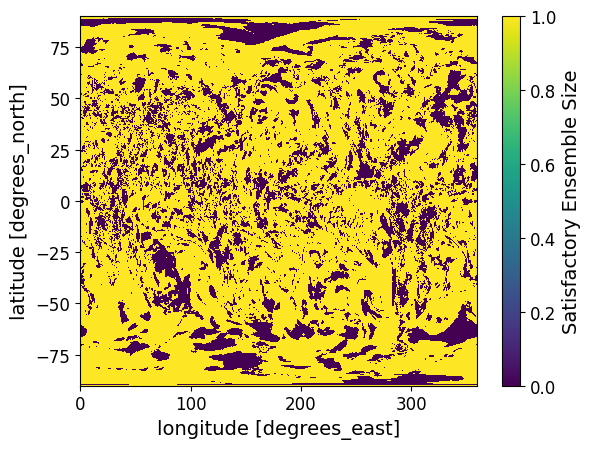

In [12]:
all_min_satisfactory_ensemble_size.isel(initial_time=0, time=0, ensemble_size=0).plot()

In [13]:
outlier_stat = all_min_satisfactory_ensemble_size.weighted(weights).mean(('lat', 'lon', 'initial_time'))

In [14]:
outlier_stat = outlier_stat.assign_coords({'ensemble_size' : [50, 100, 500, 1000, 5000, 7424]})

In [15]:
outlier_stat = 1-outlier_stat

In [16]:
outlier_stat *= 100

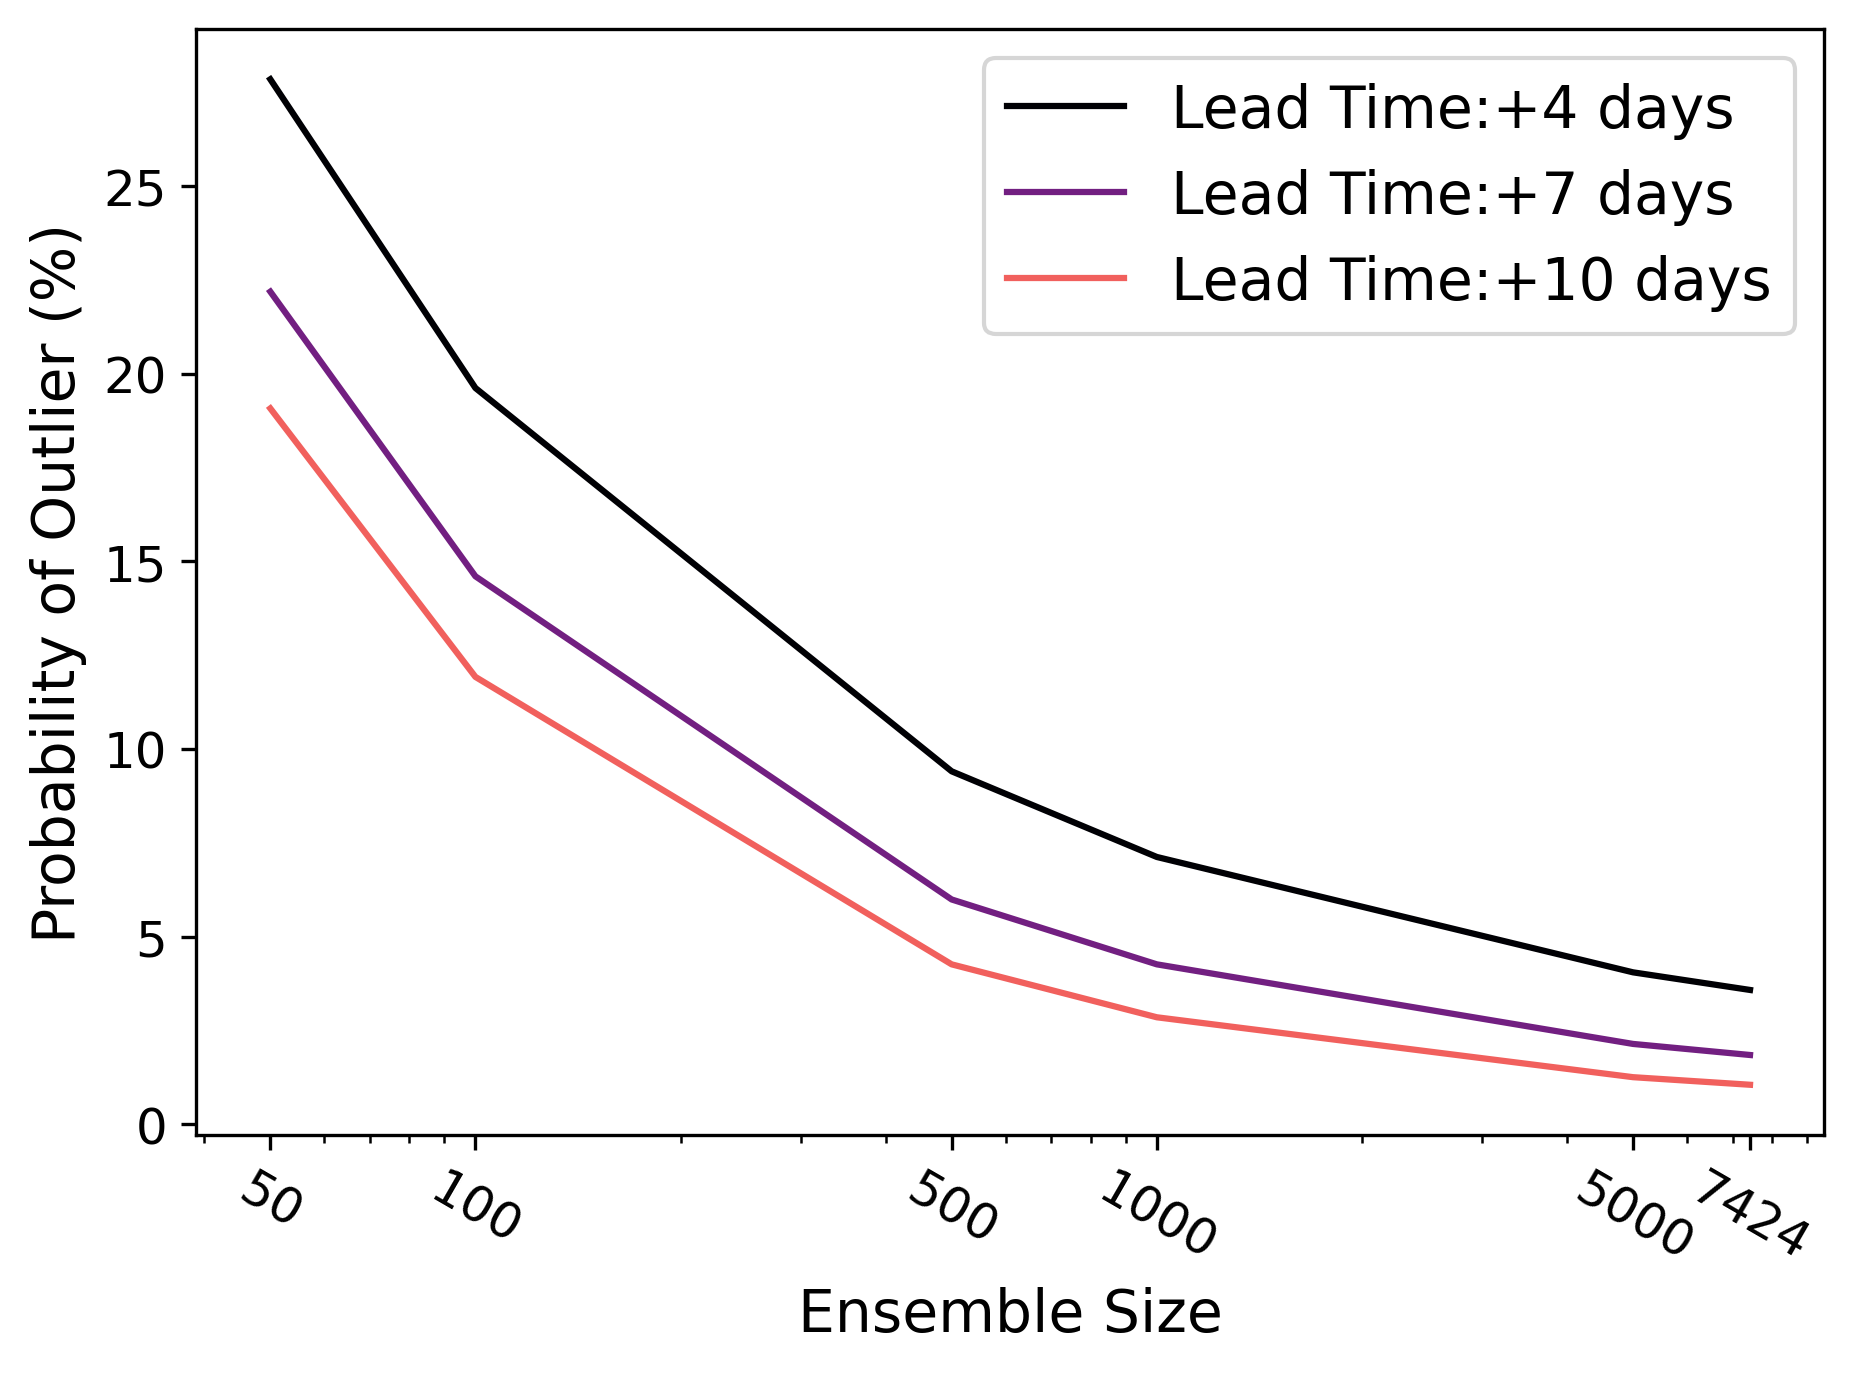

In [18]:
plt.figure(dpi=300)
cividis = plt.cm.magma(np.linspace(0, 1, 4))
outlier_stat.isel(time=[0,1,2,3]).mean('time').plot(label='Lead Time:+4 days', color=cividis[0])
outlier_stat.isel(time=[4,5,6,7]).mean('time').plot(label='Lead Time:+7 days', color=cividis[1])
outlier_stat.isel(time=[8,9,10,11]).mean('time').plot(label='Lead Time:+10 days', color=cividis[2])
plt.xscale("log")
plt.xticks([50, 100, 500, 1000, 5000, 7424], labels=[50, 100, 500, 1000, 5000, 7424], rotation=330)
plt.xlabel("Ensemble Size")
plt.ylabel("Probability of Outlier (%)")
plt.legend()
plt.title("")
plt.tight_layout()
plt.savefig("outlier_statistic.pdf")
plt.show()